<a href="https://colab.research.google.com/github/shairatabassum/PyTorch_Learning/blob/main/PyTorch_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning with PyTorch** (part IV)
A PyTorch notebook that I created while learning PyTorch through a series of tutorials on YouTube.

Source: [PyTorch Tutorials - Complete Beginner Course](https://www.youtube.com/watch?v=EMXfZB8FVUA&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4)


> **Table of contents**
> *  Save and Load Model
> *  Save a Checkpoint During Model Training
> *  Name Classification with Recurrent Neural Network (RNN)

### **Save and Load Model**

There are two methods to save the model:
* **Lazy Method:** In this case, we have to call **torch.save** and call the model and specify the path. Later when we want to load the model, we have to call **torch.load** and specify the path.
The disadvantage of this method is, the serialized data is bound to the specific classes and the exact directory structure which is used when the model is saved. 

* **State Dict:** This one is the recommended way to save the model. If we want to save our trained model and use it later for inference, then it's enough to save only the parameters.

In [1]:
import torch
import torch.nn as nn

In [2]:
# trained model 

class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = Model(n_input_features=6)

**Lazy method**

In [3]:
# save the model
FILE = "model.pth"
torch.save(model, FILE)

In [4]:
# parameters of normal model
for param in model.parameters():
    print(param)

# load the model 
loaded_model = torch.load(FILE)
loaded_model.eval()

# parameters of loaded model
for param in loaded_model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0225,  0.1785, -0.2917,  0.4076,  0.4047, -0.1926]],
       requires_grad=True)
Parameter containing:
tensor([-0.3674], requires_grad=True)
Parameter containing:
tensor([[ 0.0225,  0.1785, -0.2917,  0.4076,  0.4047, -0.1926]],
       requires_grad=True)
Parameter containing:
tensor([-0.3674], requires_grad=True)


**State dict - preferred method**

In [5]:
# save the model
FILE = "model.pth"
torch.save(model.state_dict(), FILE)

In [6]:
# parameters of normal model
for param in model.parameters():
    print(param)

# load the model
print(model.state_dict())
loaded_model = Model(n_input_features=6)
loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
loaded_model.eval()

# parameters of normal model
for param in loaded_model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0225,  0.1785, -0.2917,  0.4076,  0.4047, -0.1926]],
       requires_grad=True)
Parameter containing:
tensor([-0.3674], requires_grad=True)
OrderedDict([('linear.weight', tensor([[ 0.0225,  0.1785, -0.2917,  0.4076,  0.4047, -0.1926]])), ('linear.bias', tensor([-0.3674]))])
Parameter containing:
tensor([[ 0.0225,  0.1785, -0.2917,  0.4076,  0.4047, -0.1926]],
       requires_grad=True)
Parameter containing:
tensor([-0.3674], requires_grad=True)


### **Save a Checkpoint During Model Training**

In [10]:
# save checkpoint
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(optimizer.state_dict())

checkpoint = {
"epoch": 90,
"model_state": model.state_dict(),
"optim_state": optimizer.state_dict()
}

FILE = "checkpoint.pth"
torch.save(checkpoint, FILE)

{'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1]}]}


In [11]:
# load checkpoint
loaded_checkpoint = torch.load(FILE)
epoch = loaded_checkpoint['epoch']

model = Model(n_input_features=6)
optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0)

model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])

print(optimizer.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1]}]}


### **Name Classification with Recurrent Neural Network (RNN)**

Here the RNN is implemented from scratch instead of using nn.RNN module.

Dataset: [Names](https://download.pytorch.org/tutorial/data.zip)

In [1]:
import io
import os
import unicodedata
import string
import glob

import torch
import random

import torch
import torch.nn as nn 
import matplotlib.pyplot as plt

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

In [2]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories

In [3]:
"""
To represent a single letter, we use a “one-hot vector” of 
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.
To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.
That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

In [6]:
def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

if __name__ == '__main__':
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))
    
    category_lines, all_categories = load_data()
    print(category_lines['Arabic'][:5])
    
    print(letter_to_tensor('J')) # [1, 57]
    print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


**Name Classification - RNN**

In [4]:
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [5]:
!unzip data.zip

category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [7]:
# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])
torch.Size([1, 18])
torch.Size([1, 128])


In [8]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

German


5000 5.0 2.9386 Watt / Chinese WRONG (Scottish)
10000 10.0 2.7607 Tykal / Arabic WRONG (Czech)
15000 15.0 1.5003 La / Vietnamese CORRECT
20000 20.0 1.3697 Si / Vietnamese WRONG (Korean)
25000 25.0 2.4504 Maneates / Dutch WRONG (Greek)
30000 30.0 2.3436 Bruce / French WRONG (Scottish)
35000 35.0 1.8065 Rocha / Czech WRONG (Portuguese)
40000 40.0 1.1979 Zhinkin / Russian CORRECT
45000 45.0 0.2576 Safar / Arabic CORRECT
50000 50.0 3.6312 Finn / Chinese WRONG (Irish)
55000 55.00000000000001 1.6174 Santana / Spanish WRONG (Portuguese)
60000 60.0 0.2543 Tron / Vietnamese CORRECT
65000 65.0 0.8048 Naifeh / Arabic CORRECT
70000 70.0 1.3050 Fionn / Vietnamese WRONG (Irish)
75000 75.0 1.6954 She / Korean WRONG (Chinese)
80000 80.0 2.4101 Wakefield / German WRONG (English)
85000 85.0 2.6878 Richelieu / Scottish WRONG (French)
90000 90.0 0.0238 Pappayiorgas / Greek CORRECT
95000 95.0 0.5814 Kupfel / Czech CORRECT
100000 100.0 1.0029 Perrot / French CORRECT


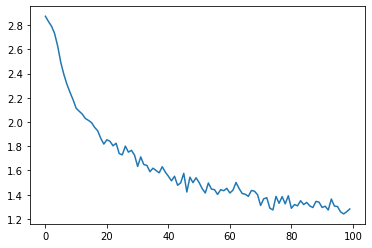

In [9]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

plt.figure()
plt.plot(all_losses)
plt.show()

In [12]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("\nInput:")
    if sentence == "quit":
        break
    
    predict(sentence)


Input:Shaira Tabassum

> Shaira Tabassum
French

Input:Tasmiah Shifa

> Tasmiah Shifa
Korean

Input:Taylor Swift

> Taylor Swift
French

Input:Chris Evans

> Chris Evans
French

Input:Daniel Redcliffe

> Daniel Redcliffe
Irish

Input:Adam Levine

> Adam Levine
French

Input:quit
